At time 10.979827089337176, the max stress is -7.2939541015625 kPa
At time 10.749279538904899, the max stress is 35.0492890625 kPa
At time 10.749279538904899, the max stress is 61.59475390625 kPa
At time 10.749279538904899, the max stress is 82.2408984375 kPa
At time 10.749279538904899, the max stress is 113.133875 kPa
At time 10.749279538904899, the max stress is 130.24928125 kPa
At time 10.749279538904899, the max stress is 146.960796875 kPa
date
2013-12-20    81.441605
2013-12-27    81.223751
Name: median shoreline elevation [m], dtype: float64
81.44160461 81.22375107 0.21785353999999302
date
2014-01-10    87.634491
2014-01-12    85.818478
Name: median shoreline elevation [m], dtype: float64
87.63449097 85.81847763 1.8160133399999978
date
2015-01-06    86.746117
2015-01-08    81.879387
Name: median shoreline elevation [m], dtype: float64
86.74611664 81.8793869 4.866729739999997
date
2016-12-28    85.347073
2017-01-02    83.084015
Name: median shoreline elevation [m], dtype: float64


/var/folders/bk/p_xwyf093rg2gtgv183x46qr0000gp/T/ipykernel_52761/516935202.py:356: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  temp = mpatches.FancyArrowPatch((tide_sub[n], depth_sb_sub[n]),\
/var/folders/bk/p_xwyf093rg2gtgv183x46qr0000gp/T/ipykernel_52761/516935202.py:363: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  history.append(mpatches.FancyArrowPatch((tide_sub[n], depth_sb_sub[n]),\
/var/folders/bk/p_xwyf093rg2gtgv183x46qr0000gp/T/ipykernel_52761/516935202.py:356: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  temp = mpatches.FancyArrowPatch((tide_sub[n], depth_sb_sub[n]),\
/var/folders/bk/p_xwyf093rg2gtgv183x46qr0000gp/T/ipykernel_52761/516935202.py:363: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  history.append(mpatches.FancyArrowPatch((tide_sub[n], depth_sb_sub[n]),\
/var

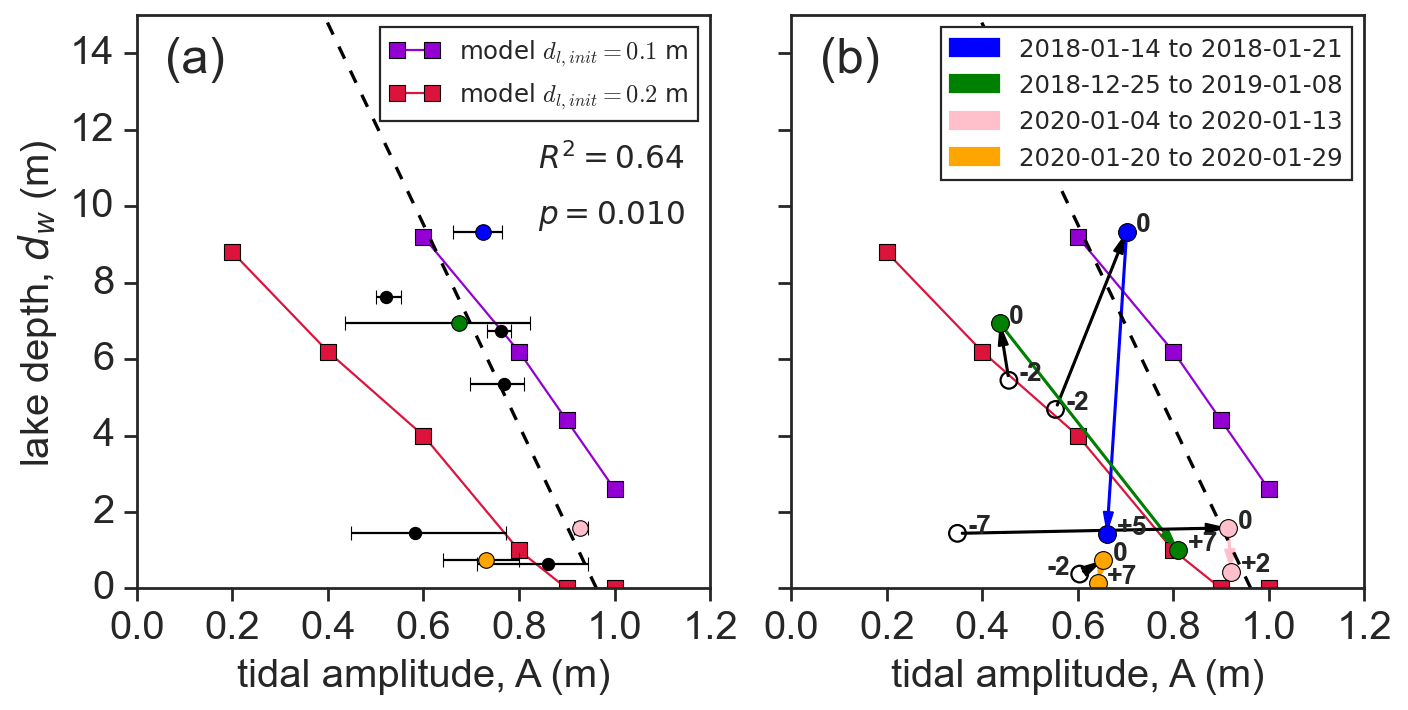

In [7]:
#======================= import essential libraries ===========================
import math
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
from scipy.signal import find_peaks
from scipy.integrate import simps 

import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.patches as mpatches
import matplotlib.font_manager as font_manager

#======================= input parameters  ===========================
Hght = 500               # Height(m)
Lngth = 2e4              # Lngth(m)               
tol = 1e-3               # Tolerance(m)
T = 0.5*3.154e7/(12.0*30.0)  # solar tide period
sea_level = Hght*0.917   # sea level(m)
fs = 14                  # FontSize
marker = 6               # MarkerType
r_lake = 0.5e3           # Lake redius
KIc = 1e5                # Ice fracture toughness

rho_w = 1e3              # water density (kg/m^3)
rho_i = 917              # ice density (kg/m^3)
g = 9.8 # m/s^2          # gravity (m/s^2)
pi = math.pi             # pi
ny = 1e4                 # y grid resolution

basin_elev = 80.0        # basin_elevation (m)
depth_basin = 90.0 - basin_elev  # basin depth (m)

# plot setting
x_left = 2
x_right = 18
d_l = 15                 # basin depth
d_f = 125                # fracture length
h_w = 10                 # lake deth
fs = 24

nt_per_year =  50*1000             # Number of timesteps per year. (tidal simulation)
t_final =  10.0/360.*3.154e7       # Final time (yr*sec_per_year). (tidal simulation)
nt = int(nt_per_year*t_final/3.154e7) # Number of time steps
dt = t_final/nt                       # Timestep size
nt = 800
#======================= functions  ===========================
# ocean tide
def interface(x):
    return 0.5*(np.abs(200-0.02*x)+(200-0.02*x))
def bedrock(x):
    return (200-0.02*x)

# semi-diurnal tide
def semi_diurnal_tide(t):
    SLC = np.sin(2*np.pi*t/(12*3600))  # tidal frequency of 2 per day
    return SLC
# semi-diurnal tide with solar modulation
def neap_spring_tide(t):
    return 1.0/2.498*np.sin(2.0*np.pi*t/(0.5*3.154e7/12.0/30.0))\
            +1.5/2.498*1.0*np.sin(2.0*np.pi*t*12.42/12/(0.5*3.154e7/12.0/30.0))
# hydrostatic water pressure
def pressure_water(depth):
    return 0.5*(rho_w*g*depth+abs(rho_w*g*depth))
# cryostatic pressure
def pressure_ice(depth):
    return rho_i*g*depth

# weight function used to calculate K1
def f1(gamma):
    return 0.3*(1-gamma**(5/4))
def f2(lam):
    return 0.5*(1-np.sin(0.5*pi*lam))*(2+np.sin(0.5*pi*lam))
def phi(lam,gamma):
    return np.sqrt(np.tan(0.5*pi*lam) / (1.0-(np.cos(0.5*pi*lam)/np.cos(0.5*pi*gamma*lam))**2))
def greens1(lam,gamma):
    return 2.0/np.sqrt(2*Hght)*(1+f1(gamma)*f2(lam))*phi(lam,gamma)

# weight function used to calculate K2 this is NOT CORRECT
def greens2(lam,gamma):
    return 2.0/np.sqrt(2)*(1+0.297*np.sqrt(1.0-gamma**2)*(1-np.cos(0.5*pi*lam)))*phi(lam,gamma)*np.sin(0.5*pi*lam*gamma)/np.sin(0.5*pi*lam)

#======================= model-based criterion  ===========================
# initial cracklength
Z_c_1 = 0.1 # case 1 (m)
Z_c_2 = 0.2 # case 2 (m)

# critical lake depth that induces drainage
critical_lake_depth_1 = []
critical_lake_depth_2 = []

# tidal amplitude
vtide = np.array([0,0.2,0.4,0.6,0.8,0.9,1.0]) 

# cases
vfile=['../results/stokes_tidal_response_U17ma_L20000_Slope2e_2_A1e_25_n3_0_mu0_30e9_deltap1e_14_deltav1e_18_C1_2e7_DX25_tide0_00',
      '../results/stokes_tidal_response_U17ma_L20000_Slope2e_2_A1e_25_n3_0_mu0_30e9_deltap1e_14_deltav1e_18_C1_2e7_DX25_tide0_20',
      '../results/stokes_tidal_response_U17ma_L20000_Slope2e_2_A1e_25_n3_0_mu0_30e9_deltap1e_14_deltav1e_18_C1_2e7_DX25_tide0_40',
      '../results/stokes_tidal_response_U17ma_L20000_Slope2e_2_A1e_25_n3_0_mu0_30e9_deltap1e_14_deltav1e_18_C1_2e7_DX25_tide0_60',
      '../results/stokes_tidal_response_U17ma_L20000_Slope2e_2_A1e_25_n3_0_mu0_30e9_deltap1e_14_deltav1e_18_C1_2e7_DX25_tide0_80',
      '../results/stokes_tidal_response_U17ma_L20000_Slope2e_2_A1e_25_n3_0_mu0_30e9_deltap1e_14_deltav1e_18_C1_2e7_DX25_tide0_90',
      '../results/stokes_tidal_response_U17ma_L20000_Slope2e_2_A1e_25_n3_0_mu0_30e9_deltap1e_14_deltav1e_18_C1_2e7_DX25_tide1_00']

for i,file in enumerate(vfile):    
    #======================= read the data ===========================
    t = np.arange(0,nt*dt,dt)
    X = np.loadtxt(file+ "/line_plot_data/X.txt", dtype='f', delimiter=' ')
    max_tension = np.loadtxt(file +'/max_tension_net.txt', dtype='f', delimiter=',')   
    max_tension_x = np.loadtxt(file +'/max_tension_x.txt', dtype='f', delimiter=',') 
    
    na = np.argmin(np.abs(t/T-10.0))               
    nb = np.argmin(np.abs(t/T-11.0))  
    max_tension = max_tension[na:nb]
    max_tension_x = max_tension_x[na:nb]
    n_frame_max  = np.argmax(max_tension)     # find the time where max sigma occurs

    # ========================= Get the max tensile stress ========================
    print('At time '+str(t[na:nb][n_frame_max]/T) + ', the max stress is '+ str(max_tension[n_frame_max]/1e3) +' kPa')
    
    xindex_max = np.argmin(abs(X-max_tension_x[n_frame_max]))
    thickness_max = Hght

    sigma_max = max_tension[n_frame_max]
    # tensile stresses for integration
    v_dl = np.arange(0,depth_basin,.2) # lake depth
    n_dl = np.shape(v_dl)[0]
    
    vlambda_1 = np.arange(0,Z_c_1,Z_c_1/100)
    vK1_max = np.zeros_like(v_dl)
    vlambda_2 = np.arange(0,Z_c_2,Z_c_2/100)
    vK2_max = np.zeros_like(v_dl)

    for k,depth_lake in enumerate(v_dl):

        # water pressure in Pascal
        p_w_1 = pressure_water(depth_lake + vlambda_1)
        p_w_2 = pressure_water(depth_lake + vlambda_2)

        # total stress
        sigma_xx_max_1 = sigma_max + p_w_1
        sigma_xx_max_2 = sigma_max + p_w_2
        
        # calculate K1_max
        dK1_max = np.zeros(np.shape(vlambda_1))   
        dK2_max = np.zeros(np.shape(vlambda_2))    


        for il,dist in enumerate(vlambda_1):
            dK1_max[il] = sigma_xx_max_1[il]*greens1(Z_c_1/thickness_max,dist/Z_c_1)
        for il,dist in enumerate(vlambda_2):
            dK2_max[il] = sigma_xx_max_2[il]*greens1(Z_c_2/thickness_max,dist/Z_c_2)

        vK1_max[k] = simps(dK1_max,vlambda_1)
        vK2_max[k] = simps(dK2_max,vlambda_2)
    
    # save the stress intensity factor K1 versus crack length
    np.savetxt(file +'/K1_max.txt', vK1_max, delimiter=',')   # K1
    np.savetxt(file +'/K1_max.txt', vK2_max, delimiter=',')   # K1
    np.savetxt(file +'/lake_depth.txt', v_dl, delimiter=',')   # lake depth series
    np.savetxt(file +'/thickness_max.txt', [thickness_max], delimiter=',')   # crack length series

    # Find the cracklength
    for nc,critical_lake_depth in enumerate([critical_lake_depth_1,critical_lake_depth_2]):
        if nc == 0:
            vK_max = vK1_max
        else:
            vK_max = vK2_max
        for il,length in enumerate(v_dl):
            if np.min(vK_max[il])/KIc > 1.0:
                critical_lake_depth.append(length)
                break
            elif il == v_dl.size-1:
                critical_lake_depth.append(float('nan'))

#================================= read in the observed data =================================
from statsmodels.stats.outliers_influence import summary_table
import matplotlib.patches as patches
# lake volume data
volume_df = pd.read_csv('../amery_data/landsat8_ameryLake_volumes_elevations.csv',\
                        sep =',',index_col='datetime', parse_dates=True)
volume_sb_df = pd.read_csv('../amery_data/landsat8_ameryLake_volumes_elevations_southBasin.csv',\
                           sep =',',index_col='date', parse_dates=True)
# racmo data
racmo_df = pd.read_csv('../amery_data/racmo2.3p2_ameryLake_meltVolume.csv',\
                       parse_dates=['time'], index_col=['time'])
racmo_df = racmo_df/6 # divide by 6 as to plot on same axis as observed lake volumes
# tidal data
tide_df = pd.read_csv('../amery_data/cats2008_ameryLake_tides.csv',\
                      parse_dates=['Time'], index_col=['Time'])
# Make yearly melt plots
years = [2013,2013,2014,2016,2017,2018,2018,2019,2019]
drainage_events = []
drainage_events.append(['2013-12-20', '2013-12-27'])
drainage_events.append(['2014-01-10', '2014-01-12'])
drainage_events.append(['2015-01-06', '2015-01-08'])
drainage_events.append(['2016-12-28', '2017-01-02'])
drainage_events.append(['2018-01-16', '2018-01-21'])
drainage_events.append(['2019-01-01', '2019-01-08'])
drainage_events.append(['2019-01-19', '2019-01-24'])
drainage_events.append(['2020-01-11', '2020-01-13'])
drainage_events.append(['2020-01-22', '2020-01-29'])

drainage_path = []
years_path=[4,5,7,8]
drainage_path.append(['2018-01-14', '2018-01-16', '2018-01-21'])
drainage_path.append(['2018-12-30', '2019-01-01', '2019-01-08'])
drainage_path.append(['2020-01-04', '2020-01-11', '2020-01-13'])
drainage_path.append(['2020-01-20', '2020-01-22', '2020-01-29'])

drainage_day_tag = []
drainage_day_tag.append(['-2', '0', '+5'])
drainage_day_tag.append(['-2', '0', '+7'])
drainage_day_tag.append(['-7', '0', '+2'])
drainage_day_tag.append(['-2', '0', '+7'])
    
# lists to store the data
lake_vol=[]
tide_amplitude=[]
lake_depth_pre_drainage=[]
lake_depth_post_drainage=[]
lake_depth_difference=[]
error = np.zeros((2,9))
var_tidal_amplitude = np.zeros((9))

colorbook = ['blue', 'green', 'pink', 'orange']

for n,year in enumerate(drainage_events):
    # lake vol, depth and tides during drainage
    vol_sub = volume_df[drainage_events[n][0]: drainage_events[n][0]]
    depth_sb_sub = volume_sb_df[drainage_events[n][0]: drainage_events[n][1]]
    tide_sub = tide_df[drainage_events[n][0]: drainage_events[n][1]]
    print(depth_sb_sub['median shoreline elevation [m]'])

    # find the mean value of daily tidal amplitude
    tide_amplitude.append(tide_sub['z_dayrange'].mean()/2.0) # max tidal amplitude
    error[0,n] = tide_sub['z_dayrange'].mean()/2.0 - tide_sub['z_dayrange'].min()/2.0 # error bar
    error[1,n] = tide_sub['z_dayrange'].max()/2.0 - tide_sub['z_dayrange'].mean()/2.0 # error bar
    var_tidal_amplitude[n]=(tide_sub['z_dayrange'].var()/4.0) # variance of tidal amplitude
    
    lake_vol.append(vol_sub['volume [m3]'][drainage_events[n][0]])
    lake_depth_pre_drainage.append(depth_sb_sub['median shoreline elevation [m]'].max() - (basin_elev))
    lake_depth_post_drainage.append(depth_sb_sub['median shoreline elevation [m]'][-1] - (basin_elev))
    lake_depth_difference.append(depth_sb_sub['median shoreline elevation [m]'].max()-\
                                depth_sb_sub['median shoreline elevation [m]'][-1])
    print(depth_sb_sub['median shoreline elevation [m]'][0],\
         depth_sb_sub['median shoreline elevation [m]'][-1],\
          depth_sb_sub['median shoreline elevation [m]'][0]-\
          depth_sb_sub['median shoreline elevation [m]'][-1])

lake_depth_data = np.array(lake_depth_pre_drainage)
tide_array=np.array(tide_amplitude) # tide array
# lake_depth_data = tide_array + 10

# sort_index = np.argsort(lake_depth_data)
# lake_depth_data = np.take_along_axis(lake_depth_data, sort_index, axis=0)
# tide_array = np.take_along_axis(tide_array, sort_index, axis=0)
# var_tidal_amplitude = np.take_along_axis(var_tidal_amplitude, sort_index, axis=0)

# ============================ create a figure =============================
fig,ax = plt.subplots(figsize=(10, 4.5), facecolor='white')
plt.rcParams["figure.dpi"] = 600
plt.style.use('classic')
sns.set_style("ticks")
sns.set_context("notebook", font_scale=0.65)
%config InlineBackend.figure_format = 'retina' # make high res plots for retina 5k displays
# ============================ panel(a) =============================
X0 = lake_depth_data
X0 = sm.add_constant(X0)
mod_wls = sm.WLS(tide_array, X0, weights=1.0/var_tidal_amplitude) # 
res_wls = mod_wls.fit()
x = np.linspace(0,40,20)
y = x*res_wls.params[1]+res_wls.params[0]
props = dict(boxstyle='round', facecolor='white', alpha=0.5)

# st, data, ss2 = summary_table(re, alpha=0.05)
# fittedvalues = data[:, 2]
# predict_mean_se  = data[:, 3]
# predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
# predict_ci_low, predict_ci_upp = data[:, 6:8].T

ax1 = plt.subplot(121)
# model criterion
model_1, = ax1.plot(vtide,np.array(critical_lake_depth_1),linestyle='-',color='darkviolet',linewidth=1,marker='s',\
                  markersize=7, label=r'model $d_{l,init}=0.1$ m', zorder=0)
model_2, = ax1.plot(vtide,np.array(critical_lake_depth_2),linestyle='-',color='crimson',linewidth=1,marker='s',\
                  markersize=7, label=r'model $d_{l,init}=0.2$ m', zorder=0)
# observations
obs = ax1.scatter(tide_array, lake_depth_data, s=25, label='observations',color='black')
reg, = ax1.plot(y,x,linestyle='--',color='black',linewidth=1.5,label='regression')
plt.errorbar(tide_array, np.array(lake_depth_data), linestyle="None",\
             xerr=error,fmt="o",markersize=0, elinewidth=1.0,color='black')

# # add the confidence interval of the slope here
# y0 = 10
# x0 = 0.25
# rect = patches.Rectangle((0,y0),x0,5,linewidth=1,edgecolor='k',facecolor='none')
# ax1.add_patch(rect)
# xx = np.arange(10,20,1)
# reg_high, = plt.plot((xx-y0)*res_wls.conf_int()[1,0]+x0,xx,linestyle='--',color='black',linewidth=1.5,label='regression')
# reg_low, = plt.plot((xx-y0)*res_wls.conf_int()[1,1]+x0,xx,linestyle='--',color='black',linewidth=1.5,label='regression')
# reg, = plt.plot((xx-y0)*res_wls.params[1]+x0,xx,linestyle='-',color='black',linewidth=2.0,label='regression')
# plt.fill_between([0,x0],[-x0/res_wls.conf_int()[1,0]+y0,y0],\
#                  [-x0/res_wls.conf_int()[1,1]+y0,y0],facecolor='grey',alpha=0.5)

print(x)
ax1.set_xlim([0,1.2])
ax1.set_ylim([0,15.0])
ax1.set_xlabel(r'tidal amplitude, A (m)',math_fontfamily='dejavusans',fontsize=fs-6)
ax1.set_ylabel(r'lake depth, $d_w$ (m)',math_fontfamily='dejavusans',fontsize=fs-6)

ax1.plot()
plt.xticks(fontsize=fs-6)
plt.yticks(fontsize=fs-6)

for k,i in enumerate(years_path):
    depth_sb_sub = lake_depth_data[i]
    tide_sub = tide_array[i]
    ax1.plot(tide_sub, depth_sb_sub, marker='o',color=colorbook[k], linewidth=0.0,markersize=7)
    print(tide_sub, depth_sb_sub)
    
plt.tight_layout()
font = font_manager.FontProperties(family='dejavusans',
                                   style='normal', size=fs-13)

lgd = ax1.legend(handles=[model_1,model_2],fontsize=fs-12,loc=1,prop=font)
textstr = r'$R^2=%.2f$' % (res_wls.rsquared)
ax1.text(0.7, 0.78, textstr, transform=ax1.transAxes, fontsize=fs-10,
        verticalalignment='top', bbox=props, math_fontfamily='dejavusans')
textstr = r'$p=%.3f$' % (res_wls.pvalues[-1])
ax1.text(0.7, 0.68, textstr, transform=ax1.transAxes, fontsize=fs-10,
        verticalalignment='top', bbox=props, math_fontfamily='dejavusans')
plt.annotate(r'(a)',xy=(0.05,0.90), xycoords='axes fraction', fontsize=fs-2)
ax1.set_aspect(1./ax1.get_data_ratio())

# ============================ panel(b) =============================
ax2 = plt.subplot(122)
# model criterion
model_1, = ax2.plot(vtide,np.array(critical_lake_depth_1),linestyle='-',color='darkviolet',linewidth=1,marker='s',\
                  markersize=7, label=r'model $d_{l,init}=0.1$ m', zorder=0)
model_2, = ax2.plot(vtide,np.array(critical_lake_depth_2),linestyle='-',color='crimson',linewidth=1,marker='s',\
                  markersize=7, label=r'model $d_{l,init}=0.2$ m', zorder=0)
ax2.plot(y,x,linestyle='--',color='black',linewidth=1.5,label='regression')
style = ArrowStyle('simple', head_length=4.0, head_width=2.0)
labelbook = ['2018-01-14 to 2018-01-21', '2018-12-25 to 2019-01-08', '2020-01-04 to 2020-01-13', '2020-01-20 to 2020-01-29']

history=[]
for i,path in enumerate(drainage_path):
    depth_sb_sub = volume_sb_df['median shoreline elevation [m]'][path]-basin_elev
    tide_sub = tide_df['z_dayrange'][path]/2.0
    for n,depth in enumerate(depth_sb_sub[0:-1]):
        if n==0:
            temp = mpatches.FancyArrowPatch((tide_sub[n], depth_sb_sub[n]),\
                                                  (tide_sub[n+1], depth_sb_sub[n+1]),\
                                                  mutation_scale=2, arrowstyle=style, edgecolor='black',\
                                                    color='black',linewidth=1, label=labelbook[i])
            flag=1
            ax2.add_patch(temp)
        else:
            history.append(mpatches.FancyArrowPatch((tide_sub[n], depth_sb_sub[n]),\
                                                  (tide_sub[n+1], depth_sb_sub[n+1]),\
                                                  mutation_scale=2, arrowstyle=style, edgecolor='black',\
                                                    color=colorbook[i], linewidth=1, label=labelbook[i]))
            ax2.add_patch(history[i])

    ax2.plot(tide_sub[1:], depth_sb_sub[1:], marker='o', markersize=8, color=colorbook[i], linewidth=0.0) # during drainage
    ax2.scatter(tide_sub[0], depth_sb_sub[0], marker='o', facecolors='none', edgecolors='black', s=56 , linewidth=1.0) # pre drainage

    for j,text in enumerate(depth_sb_sub):
        if i!=3:
            text_t = ax2.annotate(drainage_day_tag[i][j], xy=(tide_sub[j], depth_sb_sub[j]),\
                              xytext=(tide_sub[j]+0.02, depth_sb_sub[j]), weight='bold',\
                              fontsize=fs-12, math_fontfamily='dejavusans')
        elif i==3:
            if j!=0:
                text_t = ax2.annotate(drainage_day_tag[i][j], xy=(tide_sub[j], depth_sb_sub[j]),\
                              xytext=(tide_sub[j]+0.02, depth_sb_sub[j]), weight='bold',\
                              fontsize=fs-12, math_fontfamily='dejavusans')
            else:
                text_t = ax2.annotate(drainage_day_tag[i][j], xy=(tide_sub[j], depth_sb_sub[j]),\
                              xytext=(tide_sub[j]-0.07, depth_sb_sub[j]), weight='bold',\
                              fontsize=fs-12, math_fontfamily='dejavusans')
    print(tide_sub, depth_sb_sub)

# # add the confidence interval of the slope here
# y0 = 10
# x0 = 0.25
# rect = patches.Rectangle((0,y0),x0,5,linewidth=1,edgecolor='k',facecolor='none')
# ax2.add_patch(rect)
# xx = np.arange(10,20,1)
# reg_high, = plt.plot((xx-y0)*res_wls.conf_int()[1,0]+x0,xx,linestyle='--',color='black',linewidth=1.5,label='regression')
# reg_low, = plt.plot((xx-y0)*res_wls.conf_int()[1,1]+x0,xx,linestyle='--',color='black',linewidth=1.5,label='regression')
# reg, = plt.plot((xx-y0)*res_wls.params[1]+x0,xx,linestyle='-',color='black',linewidth=2.0,label='regression')
# plt.fill_between([0,x0],[-x0/res_wls.conf_int()[1,0]+y0,y0],\
#                  [-x0/res_wls.conf_int()[1,1]+y0,y0],facecolor='grey',alpha=0.5)

print(x)
ax2.set_xlim([0,1.2])
ax2.set_ylim([0,15.0])
ax2.set_xlabel(r'tidal amplitude, A (m)',math_fontfamily='dejavusans',fontsize=fs-6)
plt.setp(ax2.get_yticklabels(), visible=False)

ax2.plot()
plt.xticks(fontsize=fs-6)
plt.yticks(fontsize=fs-6)
plt.tight_layout()

font = font_manager.FontProperties(family='dejavusans',
                                   style='normal', size=fs-13)

lgd = ax2.legend(handles=[history[0],history[1],history[2],history[3]],fontsize=fs-13,loc=1,prop=font)

ax2.set_aspect(1./ax1.get_data_ratio())
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=-0.2, hspace=-0.2)
plt.annotate(r'(b)',xy=(0.05,0.90), xycoords='axes fraction', fontsize=fs-2)

plt.savefig('../figures/figure_8.jpeg',bbox_inches='tight',dpi=300)
# plt.savefig('../figures/figure_8(high-resolution).tiff',bbox_inches='tight',dpi=600)